In [2]:
!pip3 install torch torchvision

In [0]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F

In [0]:
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize((0.5,), (0.5,))
                               ])
#normalize transforms image pixel range from (0, 1) to (-1, 1)
#normalizing is important when dealing with multiple factors with wildly different ranges
#ex: income: 0-500,000 and age: 0-50
training_dataset = datasets.MNIST(root = './data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root = './data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
#shuffle false because we aren't traning it, so there's no need rto shuffle

In [0]:
def im_convert(tensor):
  image = tensor.clone().numpy()
  image = image.transpose(1, 2, 0)
  print(image.shape)
  #image is 1x28x28:
    #1 sheet (because grayscale. color would have 3 sheets, 1 for blue, 1 for green, 1 for red)
    #28x28 to represent each pixel
  #transpose makes axis 1 axis 0, axis 2 axis 1, and axis 0 axis 2
  #thus final dimensions are 28x28x1 -> 28 sheets of 28x1 vectors
  #image = image * np.array((0.5,)) + np.array((0.5,)) #denormalization
  #we denormalize when plotting to plot original data
  return image

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


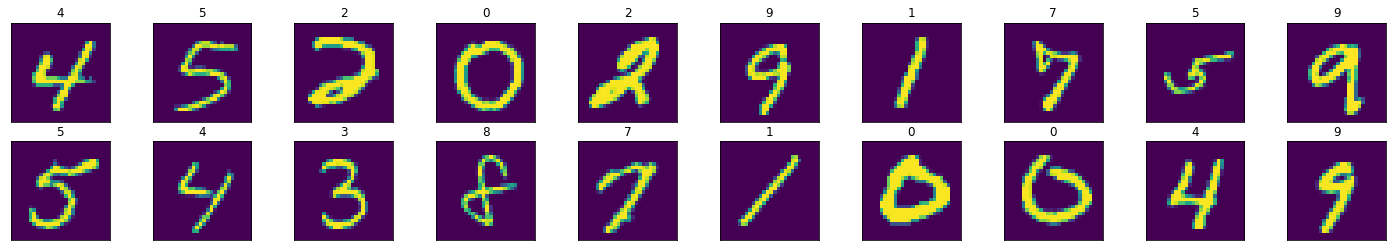

In [6]:
dataiter = iter(training_loader)
#creates an interator for each image in the loader
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
#size is 25 x 4

#to plot 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  #xticks/yticks = [] gets rid of tickmarks/gridlines in image plotting
  #2 rows, 10 columns
  plt.imshow(np.squeeze(im_convert(images[idx])))
  #plt.imshow expects 2d array so np.squeeze gets rid of extra dimension
  ax.set_title(labels[idx].item())
  #titles each image w the label (the number it's supposed to be)

In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        #nn.Conv2d takes in:
        #  num. of input channel = 1(grayscale)
        #  num. of output channels (filters) = 32
        #  kernel size = 5 -> 5x5 window
        #  padding = 2 (to make max pool stride evenly fit)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        #final dimensions: 64 7x7 channels after both conv layers
        #hidden layer dimension = 1000 nodes (empirical)
        #output dimension = 10 nodes
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
  
    def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = out.reshape(out.size(0), -1) #make it 1d
      out = self.drop_out(out)
      out = self.fc1(out)
      out = self.fc2(out)
      return out

In [21]:
model = ConvNet()
model
print(list(model.parameters()))

[Parameter containing:
tensor([[[[-0.0297, -0.0200,  0.1435,  0.1167, -0.1138],
          [ 0.0739, -0.0578,  0.1757, -0.0660, -0.1717],
          [-0.1336,  0.0116, -0.1249,  0.1671,  0.0159],
          [-0.0790, -0.1059,  0.1501,  0.0640, -0.1003],
          [ 0.0800,  0.0906, -0.0434,  0.1446,  0.0114]]],


        [[[ 0.1292,  0.1401,  0.0306, -0.0128, -0.0839],
          [-0.0357,  0.1800, -0.0240, -0.1478,  0.0046],
          [ 0.0883, -0.1646, -0.0914, -0.1372, -0.1530],
          [ 0.0630,  0.0836, -0.1786, -0.0590, -0.1256],
          [ 0.1336, -0.0841, -0.1216,  0.1685, -0.1203]]],


        [[[-0.0312, -0.0713,  0.0157, -0.1897,  0.1219],
          [-0.0500, -0.1875, -0.1247, -0.0930,  0.1586],
          [-0.1601,  0.1156,  0.1355, -0.0215,  0.1523],
          [ 0.1900, -0.1418, -0.0506, -0.0879, -0.0297],
          [ 0.1857,  0.0637,  0.1571,  0.1207,  0.0523]]],


        [[[-0.0948, -0.0379,  0.1031,  0.1468,  0.1873],
          [ 0.0695, -0.0981, -0.0523,  0.1338,  0.054

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
epochs = 5
running_loss_history = []
running_correct_history = []

for e in range(epochs):
  running_loss = 0.0 #current loss of total epoch
  running_correct = 0.0
  
  #inner loop = 1 batch
  for (images, labels) in training_loader:
    
    outputs = model(images) #nn.Module knows that forward needs to be called when it executes model(images).
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, top_preds = torch.max(outputs, 1)
    #first val is the high score, second val is the label corresponding w highest score
    #this is thus the NN's prediction on what the image is
    running_correct += torch.sum(top_preds == labels.data)
    #top_pred == labels.data returns an arrays of tues/false (0/1)
    #each index represents 1 comparison
    #total indices = # of images in that batch
    
  else: #else runs after inner for loop is done (syntax)
    epoch_loss = running_loss/(len(training_loader))
    #avg loss of all batches^
    running_loss_history.append(epoch_loss)
    epoch_accuracy = 100*running_correct.float()/(len(training_dataset))
    running_correct_history.append(epoch_accuracy)
    
    print('traning loss: {:.4f}, accuracy:{:.4f}%'.format(epoch_loss, epoch_accuracy.item()))

traning loss: 0.1007, accuracy:96.9850%
traning loss: 0.0824, accuracy:97.4850%
traning loss: 0.0714, accuracy:97.7783%
traning loss: 0.0652, accuracy:98.0083%
traning loss: 0.0590, accuracy:98.1667%


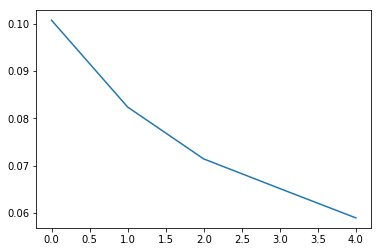

In [27]:
plt.plot(running_loss_history, label="training loss")

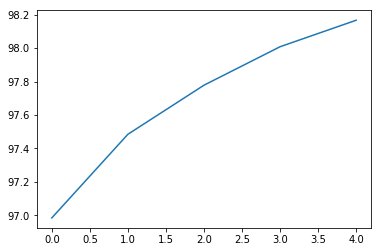

In [28]:
plt.plot(running_correct_history, label="training accuracy")

In [31]:
test_loss = 0.0 #current loss of total epoch
test_correct = 0.0
  
for images, labels in test_loader:
  outputs = model(images)
  loss = criterion(outputs, labels)
  test_loss += loss.item()
    
  _, top_preds = torch.max(outputs, 1)
  #first val is the high score, second val is the label corresponding w highest score
  #this is thus the NN's prediction on what the image is
  test_correct += torch.sum(top_preds == labels.data)
  #top_pred == labels.data returns an arrays of tues/false (0/1)
  #each index represents 1 comparison
  #total indices = # of images in that batch  
    
total_loss = test_loss/(len(test_loader))
#avg loss of all batches^
total_accuracy = 100*test_correct.float()/(len(test_dataset))
    
print('test loss: {:.4f}, test accuracy:{:.4f}%'.format(total_loss, total_accuracy.item()))

test loss: 0.0555, test accuracy:98.3300%
